### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Importing Necessary Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [2]:
cpu_count = mp.cpu_count()
print(cpu_count)

12


## 1. Exploration and Make train-test split

In [3]:
data_path = "./data/image_data/captcha/"

In [4]:
image_fns = os.listdir(data_path)
print("List Of Images: ", "\n", sorted(image_fns))
print("Total No Of Images: ", "\n", len(image_fns))
print("Length Of Captcha Letters in each image: ", "\n", [len(image_fn.split(".")[0]) for image_fn in image_fns])
print("No Of Unique Length Of Captcha Letters of all images: ", "\n", np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

List Of Images:  
 ['226md.png', '22d5n.png', '2356g.png', '23mdg.png', '23n88.png', '243mm.png', '244e2.png', '245y5.png', '24f6w.png', '24pew.png', '25257.png', '253dc.png', '25egp.png', '25m6p.png', '25p2m.png', '25w53.png', '264m5.png', '268g2.png', '28348.png', '28x47.png', '2b827.png', '2bg48.png', '2cegf.png', '2cg58.png', '2cgyx.png', '2en7g.png', '2enf4.png', '2fxgd.png', '2g783.png', '2g7nm.png', '2gyb6.png', '2mg87.png', '2mpnn.png', '2n73f.png', '2nbc5.jpg', '2nbcx.png', '2nf26.png', '2npg6.png', '2nx38.png', '2p2y8.png', '2pfpn.png', '2w4y7.png', '2wc38.png', '2wx73.png', '2x7bm.png', '2xc2n.png', '2ycn8.png', '2yggg.png', '325fb.png', '32cnn.png', '32dnn.png', '33b22.png', '33f7m.png', '33n73.png', '33ng4.png', '33p4e.png', '34b84.png', '34fxm.png', '34pcn.png', '368y5.png', '36bc2.png', '36nx4.png', '36w25.png', '373gb.png', '377xx.png', '378e5.png', '37d52.png', '37ep6.png', '387g2.png', '38n57.png', '3b4we.png', '3bd8f.png', '3bfnd.png', '3bnyf.png', '3bx86.png', '3c7d

In [5]:
# checking if there is any image captcha with more than 5 letters
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0])!= 5 :
           print(idx, image_fn)

In [6]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
print("Images Filenames with extension Removed: ", "\n", image_ns)


image_ns = "".join(image_ns)

chars = sorted(list(set(list(image_ns))))

print("Total No of Unique Letters of all captcha images: ", "\n", len(chars))

print("Unique Letters of all captcha images: ", "\n", chars)

Images Filenames with extension Removed:  
 ['6gnm3', '3bfnd', 'd8xcn', 'nfcb5', 'n373n', 'nwfde', '8bbw8', '8b735', 'w4x2m', '6end3', '3ye2e', '7gmf3', 'y5dpp', 'f35xp', 'ncww7', '5325m', '4b2pw', 'xfn6n', 'gfp54', '8gmc4', '8w754', 'c6f8g', '5f3gf', 'n6f4b', 'pdyc8', 'egxmp', '474ff', 'bc8nf', '46mbm', '38n57', '4cn7b', 'dd5w5', 'm4fd8', 'e25xg', '87nym', '6e2dg', '3nnpw', 'pym7p', 'bw6n6', 'n7g4f', '3mxdn', 'pw5nc', 'geyn5', 'bf52c', '6wb76', 'f6ne5', '6ydyp', 'fg7mg', 'n5wbg', '62fgn', 'n464c', 'pnmxf', 'x7422', 'yf424', 'pe4xn', '5n732', '77n6g', 'edwny', 'xp24p', 'xcmbp', 'edg3p', '7634y', 'pgg3n', 'g7fmc', 'be6np', 'nfndw', '5mcy7', 'yew6p', 'g6n7x', '3xng6', '53mn8', 'y32yy', 'w4cnn', 'yyg5g', 'dfnx4', '5fyem', '36bc2', 'gy8xb', 'pmg55', '6xen4', 'n7ff2', 'cwgyx', '8n4n8', '34b84', 'y7d75', 'mc35n', 'e43ym', 'e4gd7', 'mye68', '3ebpw', '6xpme', 'nbwnn', 'y7mnm', 'mg5nn', '2g7nm', 'g842c', 'x3deb', '6cm6m', '65m85', 'c482b', 'y53c2', 'yemy4', '3ebnn', 'nnn5p', 'gp7c5', 'pg2pm', '

In [7]:
image_fns_train, image_fns_test = train_test_split(image_fns,test_size=0.25, random_state=42)
print(len(image_fns_train), len(image_fns_test))

802 268


## 2. Define character maps

In [8]:
vocabulary = ["-"] + chars
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


## 3. Define data loader

In [9]:
batch_size = 16

In [10]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [11]:
# Creating Dataset based on the train_test_split data
# NOTE : there's no specific directory for test , train data basically we are splitting the train test split on the code itself
trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)

In [12]:
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader))

51 17


In [13]:
print(trainset.__getitem__(0))

(tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
         ...,
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
         [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],

        [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
         ...,
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
         [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],

        [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
         [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2

In [14]:
print(trainset.__getitem__(801)[0].shape)

torch.Size([3, 50, 200])


In [15]:
dataiter = iter(train_loader)
image_batch, text_batch = next(dataiter)
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('7p852', 'pcmcc', '8n56m', 'fp382', 'nnn5p', 'nbcgb', 'ndme7', 'nm248', 'pn7pn', '3wnd3', 'mdyp7', 'ncfgb', 'm4g8g', 'ng46m', 'x2cnn', '63pxe')


## 4. Define model

In [16]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [18]:
resnet = resnet18(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/coochie/vscode/DeepLearing/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coochie/vscode/DeepLearing/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [21]:
crnn = CRNN(num_chars)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [22]:
print(crnn)

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [23]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('7p852', 'pcmcc', '8n56m', 'fp382', 'nnn5p', 'nbcgb', 'ndme7', 'nm248', 'pn7pn', '3wnd3', 'mdyp7', 'ncfgb', 'm4g8g', 'ng46m', 'x2cnn', '63pxe')
torch.Size([10, 16, 20])


## 5. Define loss

In [24]:
criterion = nn.CTCLoss(blank=0)

In [25]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [26]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [27]:
compute_loss(text_batch, text_batch_logits)

tensor(4.5756, grad_fn=<MeanBackward0>)

## 6. Train model

In [28]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [29]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

/home/coochie/vscode/DeepLearing/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [30]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [31]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:3.016931052301444    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.42048680081087    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.9501964531692804    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.6089693307876587    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.3858475988986445    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.2229433527179794    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.1132885428035961    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.0416284039908765    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:0.9776269080592137    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:0.9315464718669069    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:0.8902110515856275    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:0.8852601939556646    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:0.9085145148576474    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.9178545124390546    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.8080321410123039    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.7653991030711754    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.7756858491430095    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.8430127922226401    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.8620087223894456    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.7543906686352748    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.7088126692117429    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.7032255132993063    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.6960219986298505    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.7328883467936048    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.8922968600310531    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.7963068894311494    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.6968091469185025    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.668105305409899    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.6616709407638101    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.6596620713963228    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.7119742889030307    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.7575767799919727    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.7347457292033177    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.7090315690227583    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.6425830850414201    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.6190943390715355    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.6194447197166144    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.6222294849507949    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.6276961085843105    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.6147419447992363    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.6657625086167279    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.8199735681215922    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.7689110274408378    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.6475701600897545    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.6598726312319437    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.6380481988775963    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.5774889377986684    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.5491256737241558    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.5391465244339961    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.5344550755678439    NumUpdates:51


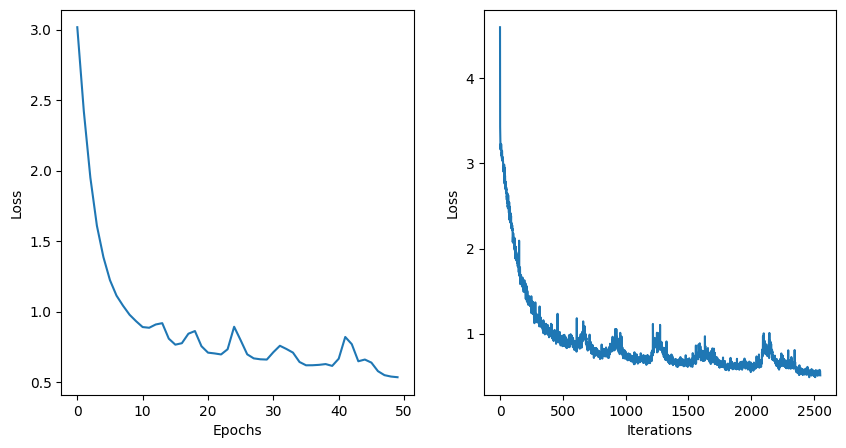

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [33]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [34]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/51 [00:00<?, ?it/s]

In [35]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [36]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,5nxnn,55nnxxnn-n
1,4433m,44-43333mm
2,8eggg,88eeggg-gg
3,7cdge,77ccddggee
4,6dd2y,66dddd22yy


In [37]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,4dw3w,44ddww33ww
1,n8pfe,nn88ppffee
2,53mn8,5533mmnn88
3,pdcp4,ppddccpp44
4,8d4wm,88dd44wwmm


In [38]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [39]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,5nxnn,55nnxxnn-n,5nxnn
1,4433m,44-43333mm,443m
2,8eggg,88eeggg-gg,8egg
3,7cdge,77ccddggee,7cdge
4,6dd2y,66dddd22yy,6d2y


In [40]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,4dw3w,44ddww33ww,4dw3w
1,n8pfe,nn88ppffee,n8pfe
2,53mn8,5533mmnn88,53mn8
3,pdcp4,ppddccpp44,pdcp4
4,8d4wm,88dd44wwmm,8d4wm


## 8. Evaluate the model

In [41]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
6,5mfff,55mmff--ff,5mff
9,5nnff,55nn-nffff,5nnf
10,ddxpp,d--dxxpppp,ddxp
18,yy824,yyyy882244,y824
27,nnn57,n----n5577,nn57
29,5expp,55eexxpppp,5exp
33,23n88,2233nn8888,23n8
36,x277e,xx227777ee,x27e
47,377xx,337777xxxx,37x
58,g888x,gg88--88xx,g88x


In [42]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    37
3     2
Name: count, dtype: int64


In [43]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected


In [44]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9164588528678305
0.8544776119402985
